<a href="https://colab.research.google.com/github/hudza03/pbahudza2025/blob/main/0_week2pbahudza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


In [2]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
import nltk

from collections import Counter
from nltk.tokenize import word_tokenize
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [3]:
# Scrapping Google Apps Review - eg TransJatim
# NLP Pipeline PBA / Genap 2025

APP_ID = "ngi.muchi.jatimajaib"  # TransJatim
LANG = "id"
COUNTRY = "id"

app_info = app(APP_ID, lang=LANG, country=COUNTRY)
print("App Title :", app_info.get("title"))
print("App ID    :", APP_ID)
print("Installs  :", app_info.get("installs"))
print("Score     :", app_info.get("score"))
print("Ratings   :", app_info.get("ratings"))
print("Updated   :", app_info.get("updated"))


App Title : TRANSJATIM - AJAIB
App ID    : ngi.muchi.jatimajaib
Installs  : 500.000+
Score     : 4.609375
Ratings   : 1851
Updated   : 1765867856


In [4]:
from google_play_scraper import app, Sort, reviews_all

mbb_reviews = reviews_all(
    'ngi.muchi.jatimajaib',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [5]:
df_mbbrev = pd.DataFrame(np.array(mbb_reviews),columns=['content'])
df_mbbrev = df_mbbrev.join(pd.DataFrame(df_mbbrev.pop('content').tolist()))

In [6]:
def mask_username(username):
    if pd.isna(username):
        return username
    username = str(username)
    if len(username) <= 4:
        return "*" * len(username)
    return username[:2] + "*" * (len(username)-4) + username[-2:]

df_mbbrev['userName'] = df_mbbrev['userName'].apply(mask_username)

In [7]:
df_mbbrev.to_csv("transjatimajaib_raw.csv", index=False)

In [8]:
df_mbbrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,78c416e3-9ba3-4a19-95d7-414fe40b0c4d,Na************la,https://play-lh.googleusercontent.com/a-/ALV-U...,hopefully there will be more routes in Malang ...,4,0,1.2.9,2025-12-28 00:06:49,None,NaT,1.2.9
1,9c43d2ae-31a7-48d3-a669-5351f751d0b3,M.*********************ni,https://play-lh.googleusercontent.com/a-/ALV-U...,Gabisa login google di versi terbarunya di red...,1,0,1.2.9,2025-12-21 22:45:47,None,NaT,1.2.9
2,ac12fd97-5849-4af7-a4eb-033ae7f2673a,Ro*********ah,https://play-lh.googleusercontent.com/a-/ALV-U...,"gps-nya kadang sering ga akurat, adminnya resp...",5,0,1.2.7,2025-12-18 12:17:32,None,NaT,1.2.7
3,7392326f-7453-4142-bcaf-c76eafc72fd9,Fa*********dh,https://play-lh.googleusercontent.com/a-/ALV-U...,"gabisa login aplikasi, loading terus",1,0,1.2.8,2025-12-16 00:54:00,"Halo kak,Setelah kami lakukan pengecekan kondi...",2025-11-24 08:08:53,1.2.8
4,f27806d1-6920-4b29-9b28-818e2aa99c37,Gi**********di,https://play-lh.googleusercontent.com/a-/ALV-U...,bobrok ga bisa login,1,0,None,2025-12-11 05:45:00,None,NaT,None
...,...,...,...,...,...,...,...,...,...,...,...
97,1a76bb28-b22c-4105-a252-7fafc265a9a7,Bu******************ra,https://play-lh.googleusercontent.com/a-/ALV-U...,"1. Mohon ditambahkan Halte Alun-Alun Sidoarjo,...",4,1,1.0.3,2022-08-23 02:06:22,None,NaT,1.0.3
98,9864012f-6e8b-4d2f-ad3f-8ca247029580,Ag**********to,https://play-lh.googleusercontent.com/a-/ALV-U...,"Tolong opsi pembayarannya diperbanyak, moga ad...",4,0,1.0.3,2022-08-22 14:30:36,Terima kasih atas masukannya\nUntuk pembayaran...,2022-08-27 01:21:16,1.0.3
99,536c1f71-4cd1-4a1b-b9de-4dd05599d9eb,GR****************************AW,https://play-lh.googleusercontent.com/a-/ALV-U...,top,5,0,1.0.3,2022-08-21 08:13:05,terimakasih ka atas support nya kepada transjatim,2023-03-08 06:07:15,1.0.3
100,2a3a2491-d904-4b72-bd06-a87c89b6efd9,im**********no,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi nya sudah bagus. Mohon untuk metode p...,5,1,1.0.3,2022-08-20 06:18:50,Pembayaran bisa dilakukan secara tunai dan non...,2022-08-27 06:18:55,1.0.3


In [9]:
df_mbbrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              102 non-null    object        
 1   userName              102 non-null    object        
 2   userImage             102 non-null    object        
 3   content               102 non-null    object        
 4   score                 102 non-null    int64         
 5   thumbsUpCount         102 non-null    int64         
 6   reviewCreatedVersion  84 non-null     object        
 7   at                    102 non-null    datetime64[ns]
 8   replyContent          36 non-null     object        
 9   repliedAt             36 non-null     datetime64[ns]
 10  appVersion            84 non-null     object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 8.9+ KB


Data preprocessing

In [10]:
df_mbbrev['content'] = df_mbbrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print ("Before lowercasing:")
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])
print ("\nAfter lowercasing:")
df_mbbrev['content']= df_mbbrev['content'].apply(lambda x: x.lower())
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])

Before lowercasing:
masa payment gateway dimonopoli astra, harus pake astrapay, udah gitu tiket yang tersedia cuma umum, gaada tiket pelajar, percuma user interface bagus tapi dibandingkan sama aplikasi gobis yg jelek aja masih kalah
Gabisa login google di versi terbarunya di redmi note 14 pro, loading doang ga muncul pop up buat milih akun login nya
aplikasi dengan peta integrasi terbaik 🫰

After lowercasing:
masa payment gateway dimonopoli astra, harus pake astrapay, udah gitu tiket yang tersedia cuma umum, gaada tiket pelajar, percuma user interface bagus tapi dibandingkan sama aplikasi gobis yg jelek aja masih kalah
gabisa login google di versi terbarunya di redmi note 14 pro, loading doang ga muncul pop up buat milih akun login nya
aplikasi dengan peta integrasi terbaik 🫰


In [11]:
df_mbbrev['tokens'] = df_mbbrev['content'].str.lower().str.split()
all_tokens = [word for tokens in df_mbbrev['tokens'] for word in tokens]
counter = Counter(all_tokens)
top_50 = counter.most_common(50)
print(top_50)

[('di', 43), ('bisa', 24), ('untuk', 23), ('aplikasi', 21), ('dan', 21), ('sudah', 19), ('ada', 19), ('sangat', 18), ('halte', 16), ('dengan', 16), ('tidak', 14), ('rute', 14), ('yg', 13), ('bus', 13), ('penumpang', 12), ('lebih', 12), ('atau', 12), ('membantu', 11), ('armada', 11), ('login', 10), ('yang', 10), ('banyak', 10), ('ke', 9), ('pembayaran', 9), ('nya', 8), ('ini', 8), ('tolong', 8), ('kalau', 8), ('dari', 8), ('ga', 7), ('lama', 7), ('tapi', 7), ('2', 7), ('jam', 7), ('jangan', 7), ('terminal', 7), ('-', 7), ('info', 7), ('hanya', 6), ('saya', 6), ('antar', 6), ('terlalu', 6), ('karena', 6), ('lagi', 6), ('bunder', 6), ('mohon', 6), ('ditambahkan', 6), ('metode', 6), ('jumlah', 6), ('google', 5)]


In [12]:
# Create stopword remover
factory = StopWordRemoverFactory()
id_stopwords = set(factory.get_stop_words())

# Apply stopword removal to the 'content' column
df_mbbrev['tokens_stopword_rm'] = df_mbbrev['tokens'].apply(lambda tokens: [w for w in tokens if w not in id_stopwords])

In [13]:
nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))

df_mbbrev['tokens_stopword_rm'] = df_mbbrev['tokens_stopword_rm'].apply(
    lambda tokens: [w for w in tokens if w not in english_stopwords]
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print(df_mbbrev['tokens_stopword_rm'])

0      [hopefully, routes, malang, esp, arah, singosari]
1      [gabisa, login, google, versi, terbarunya, red...
2      [gps-nya, kadang, sering, ga, akurat,, adminny...
3             [gabisa, login, aplikasi,, loading, terus]
4                                    [bobrok, ga, login]
                             ...                        
97     [1., mohon, ditambahkan, halte, alun-alun, sid...
98     [opsi, pembayarannya, diperbanyak,, moga, arah...
99                                                 [top]
100    [aplikasi, nya, bagus., mohon, metode, pembaya...
101                   [kalau, ditambahkan, halte, perak]
Name: tokens_stopword_rm, Length: 102, dtype: object


In [15]:
# Download WordNet
nltk.download('wordnet')
nltk.download('omw-1.4')

# English Lemmatizer
lemmatizer = WordNetLemmatizer()

# Indonesian Stemmer
factory = StemmerFactory()
indo_stemmer = factory.create_stemmer()

# Function to stem/lemmatize per token
def stem_or_lemmatize(tokens):
    processed = []
    for w in tokens:
        # Simple heuristic: check if word is ASCII
        if w.isascii():
            processed.append(lemmatizer.lemmatize(w))
        else:
            processed.append(indo_stemmer.stem(w))
    return processed

# Apply to your DataFrame
df_mbbrev['tokens_stemmed'] = df_mbbrev['tokens'].apply(stem_or_lemmatize)

print(df_mbbrev[['tokens', 'tokens_stemmed']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                              tokens  \
0  [hopefully, there, will, be, more, routes, in,...   
1  [gabisa, login, google, di, versi, terbarunya,...   
2  [gps-nya, kadang, sering, ga, akurat,, adminny...   
3         [gabisa, login, aplikasi,, loading, terus]   
4                          [bobrok, ga, bisa, login]   

                                      tokens_stemmed  
0  [hopefully, there, will, be, more, route, in, ...  
1  [gabisa, login, google, di, versi, terbarunya,...  
2  [gps-nya, kadang, sering, ga, akurat,, adminny...  
3         [gabisa, login, aplikasi,, loading, terus]  
4                          [bobrok, ga, bisa, login]  


In [16]:
# mengembalikan stemmed tokens mjd strings kembali
df_mbbrev['clean_text'] = df_mbbrev['tokens_stemmed'].apply(lambda x: ' '.join(x))

In [17]:
from textblob import TextBlob

# On raw text (as originally written)
df_mbbrev['raw_polarity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['raw_subjectivity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

# On cleaned/stemmed text
df_mbbrev['clean_polarity'] = df_mbbrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['clean_subjectivity'] = df_mbbrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [18]:
df_analysis = df_mbbrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

In [19]:
#Check review scores
df_mbbrev['score'].value_counts()

,count
score,
5,49
1,25
4,14
3,11
2,3


In [20]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.9 MB/s eta 0:00:00


In [21]:
from textblob import TextBlob
# Handle None values in 'content' column by replacing them with empty strings
df_mbbrev['sentiment_polarity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['sentiment_subjective'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [22]:
df_raw = df_mbbrev.loc[:,["content","score","raw_polarity", "raw_subjectivity"]]
df_clean = df_mbbrev.loc[:,["content","score","clean_polarity", "clean_subjectivity"]]

In [23]:
df_raw

,content,score,raw_polarity,raw_subjectivity
0,hopefully there will be more routes in malang esp ke arah singosari,4,0.50,0.5
1,"gabisa login google di versi terbarunya di redmi note 14 pro, loading doang ga muncul pop up buat milih akun login nya",1,0.00,0.0
2,"gps-nya kadang sering ga akurat, adminnya responsive meskipun lama balesnya. tapi secara general, apps ini membantu bgt sih. semoga tj luxury koridor 4 segera beroprasi, aaamiiin...",5,0.05,0.5
3,"gabisa login aplikasi, loading terus",1,0.00,0.0
4,bobrok ga bisa login,1,0.00,0.0
...,...,...,...,...
97,"1. mohon ditambahkan halte alun-alun sidoarjo, mengingat tingginya minat penumpang yg naik dan turun di lokasi tsb. 2. running text alangkah lebih informatifnya kalau diganti dgn info tujuan atau ...",4,0.00,0.0
98,"tolong opsi pembayarannya diperbanyak, moga ada yang ke arah sidoarjo barat/mojokerto juga.",4,0.00,0.0
99,top,5,0.50,0.5
100,aplikasi nya sudah bagus. mohon untuk metode pembayaran nya utk diperbanyak e-walet nya. trims,5,0.00,0.0


In [24]:
df_clean

,content,score,clean_polarity,clean_subjectivity
0,hopefully there will be more routes in malang esp ke arah singosari,4,0.50,0.5
1,"gabisa login google di versi terbarunya di redmi note 14 pro, loading doang ga muncul pop up buat milih akun login nya",1,0.00,0.0
2,"gps-nya kadang sering ga akurat, adminnya responsive meskipun lama balesnya. tapi secara general, apps ini membantu bgt sih. semoga tj luxury koridor 4 segera beroprasi, aaamiiin...",5,0.05,0.5
3,"gabisa login aplikasi, loading terus",1,0.00,0.0
4,bobrok ga bisa login,1,0.00,0.0
...,...,...,...,...
97,"1. mohon ditambahkan halte alun-alun sidoarjo, mengingat tingginya minat penumpang yg naik dan turun di lokasi tsb. 2. running text alangkah lebih informatifnya kalau diganti dgn info tujuan atau ...",4,0.00,0.0
98,"tolong opsi pembayarannya diperbanyak, moga ada yang ke arah sidoarjo barat/mojokerto juga.",4,0.00,0.0
99,top,5,0.50,0.5
100,aplikasi nya sudah bagus. mohon untuk metode pembayaran nya utk diperbanyak e-walet nya. trims,5,0.00,0.0


In [26]:
# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


In [27]:
import string

df_mbbrev['wordCount'] = [len(review.split()) for review in df_mbbrev['content']]
df_mbbrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
    for review in df_mbbrev['content']]
df_mbbrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
    for review in df_mbbrev['content']]

In [28]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_mbbrev['sentiment_rating'] = df_mbbrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [29]:
df_mbbrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,hopefully there will be more routes in malang esp ke arah singosari,4,0.50,0.5,Positive
1,"gabisa login google di versi terbarunya di redmi note 14 pro, loading doang ga muncul pop up buat milih akun login nya",1,0.00,0.0,Negative
2,"gps-nya kadang sering ga akurat, adminnya responsive meskipun lama balesnya. tapi secara general, apps ini membantu bgt sih. semoga tj luxury koridor 4 segera beroprasi, aaamiiin...",5,0.05,0.5,Positive
3,"gabisa login aplikasi, loading terus",1,0.00,0.0,Negative
4,bobrok ga bisa login,1,0.00,0.0,Negative
...,...,...,...,...,...
97,"1. mohon ditambahkan halte alun-alun sidoarjo, mengingat tingginya minat penumpang yg naik dan turun di lokasi tsb. 2. running text alangkah lebih informatifnya kalau diganti dgn info tujuan atau ...",4,0.00,0.0,Positive
98,"tolong opsi pembayarannya diperbanyak, moga ada yang ke arah sidoarjo barat/mojokerto juga.",4,0.00,0.0,Positive
99,top,5,0.50,0.5,Positive
100,aplikasi nya sudah bagus. mohon untuk metode pembayaran nya utk diperbanyak e-walet nya. trims,5,0.00,0.0,Positive


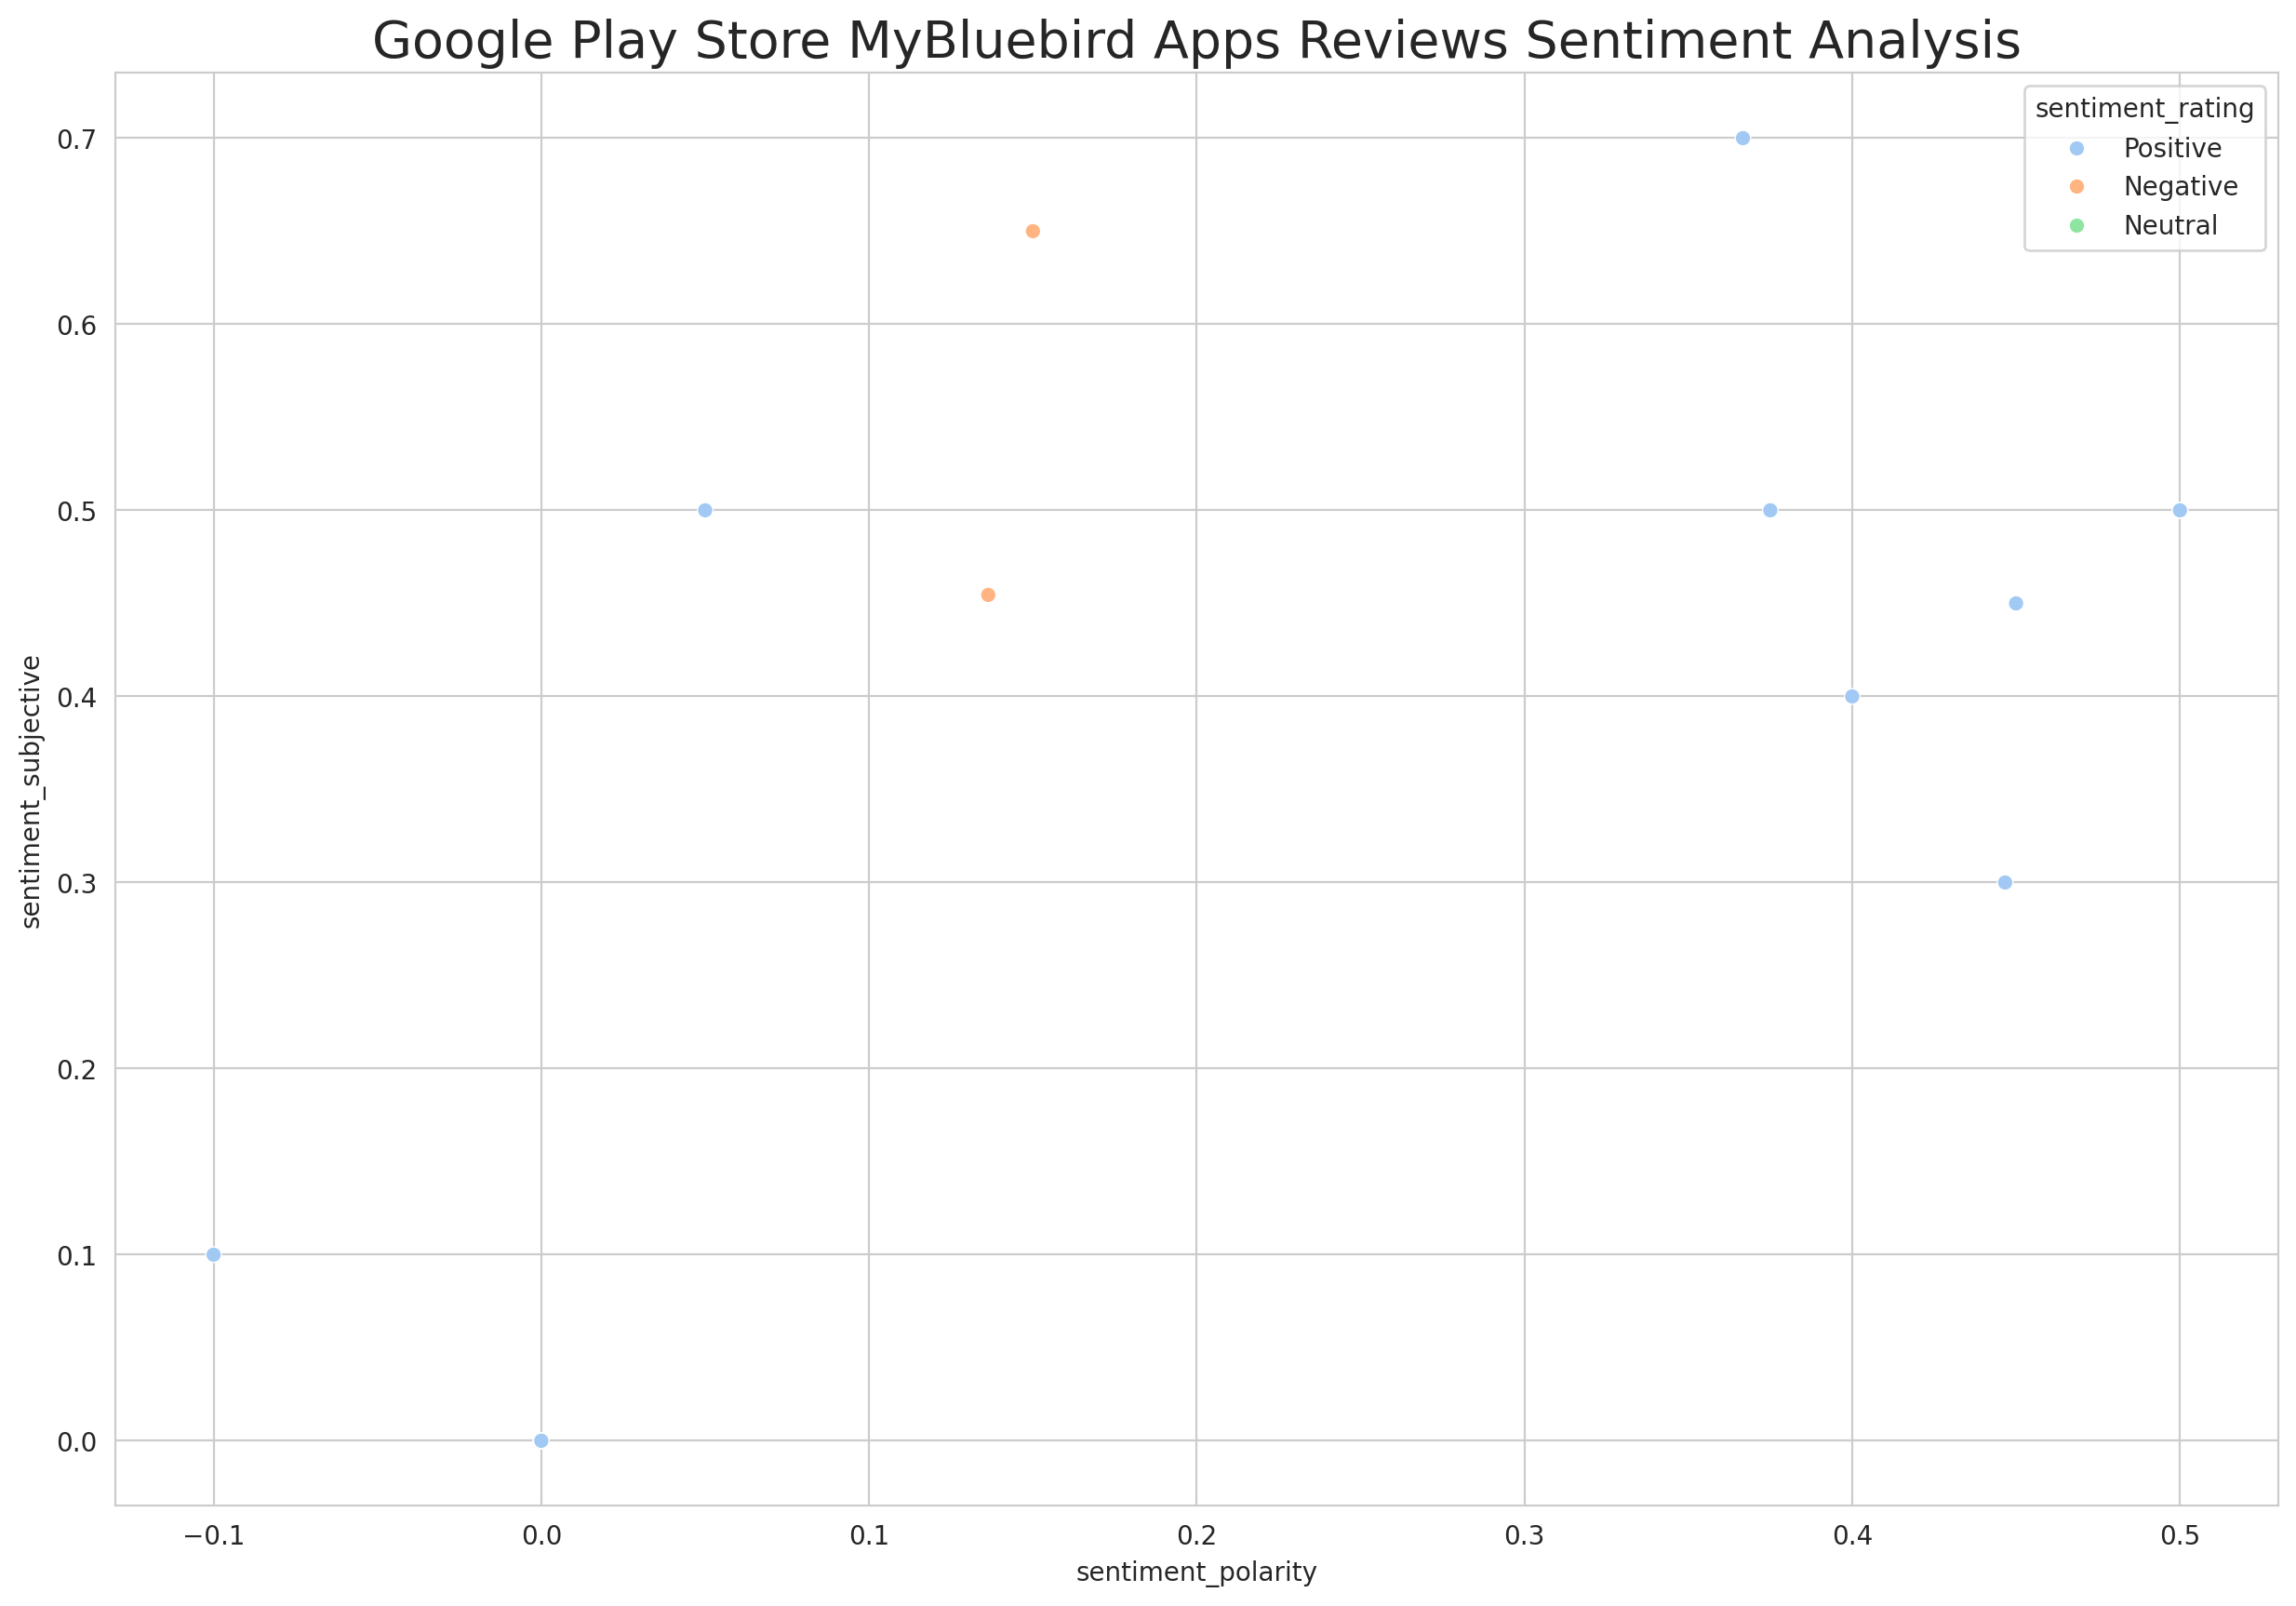

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_mbbrev['sentiment_polarity'], y=df_mbbrev['sentiment_subjective'],
                hue=df_mbbrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store MyBluebird Apps Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [31]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

In [35]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

In [37]:
# Save clean dataset
df_mbbrev.to_csv('transjatimajaib_clean.csv', index=False)
print("Clean dataset saved as transjatimajaib_clean.csv")

Clean dataset saved as transjatimajaib_clean.csv
